In [1]:
!nvidia-smi

Fri Dec 29 11:37:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P3              12W /  30W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import cv2
import os
import json
from random import choice
import torch
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from torchvision import models, transforms
import albumentations as A
from tqdm import tqdm
from ultralytics import YOLO
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Get a list of file names
images_special_car = listdir('./Dataset/Spesial_car/') 
image_rest = listdir('./Dataset/Rest/')

# Transfer them to the dataframe
data_special_car = pd.DataFrame(images_special_car, columns=['src'])
data_rest = pd.DataFrame(image_rest, columns=['src'])

# Add target attributes
data_special_car['label'] = 1 # Specialty cars
data_rest['label'] = 0 # Simple pictures

# Объединяем 
data = pd.concat([data_special_car, data_rest], ignore_index=True)
data # Let's take a look at the resulting dataframe

,src,label
0,0000.jpg,1
1,0001.jpg,1
2,0002.png,1
3,0003.jpg,1
4,0004.png,1
...,...,...
1605,0911.jpg,0
1606,0912.jpg,0
1607,0913.jpg,0
1608,0914.jpg,0


In [4]:
# Target attribute distribution
data['label'].value_counts() / data.shape[0] * 100 

label
0    56.89441
1    43.10559
Name: count, dtype: float64

You can see that there are more photos without specialty autos in the dataset

# 2. Augmentation of photos and their subsequent processing

## 2.1. Description of augmentation rules

In [5]:
# Describe the augmentation techniques
transform1 = A.Compose([
    A.HorizontalFlip(p=0.05), # Vertical rotation
    A.Blur(p=0.25) # Blur effect on the image
])
transform2 = A.Compose([
    A.HorizontalFlip(p=0.05), # Vertical rotation
    A.ToGray() # Convert the image to a B&W image
])
transform3 = A.Compose([
    A.HorizontalFlip(p=0.5), # Vertical rotation
    A.RandomContrast(p=0.25) # Increasing contarstability
])
transform4 = A.Compose([
    A.HorizontalFlip(p=0.05), # Vertical rotation
    A.JpegCompression(p=0.25) # Adding noise to an image
])

## 2.2. Processing of each photo and their augmentation

In [6]:
%%time
X = [] # Photographs in matrix format
y = [] # Classes of photographs
for i in tqdm(range(len(data))):
    image = data.loc[i,'src'] # Get the path to the image
    if (data.loc[i, 'label'] == 1): # If there's a special car in the picture
        image = cv2.imread('./Dataset/Spesial_car/'+image, cv2.IMREAD_COLOR) 
    else: # If it's not a special car in the picture
        image = cv2.imread('./Dataset/Rest/'+image, cv2.IMREAD_COLOR) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the color palette of the photo from BGR to RGB 
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_AREA) # Resize the image 

    # We're augmenting the photos
    transform = None
    transform_old = None
    for _ in range(2):
        while True:
            transform = choice([transform1, transform2, transform3, transform4])
            if transforms != transform_old:
                transformed_image = transform(image=image)
                X.append(transformed_image["image"])
                transform_old = transform
                break
    # Add labels for images
    for _ in range(3):
        y.append(data.loc[i, 'label'])

# Normalize the data
X_torch = np.array(X)
X_torch = X_torch.astype('float32')
X_torch = X_torch / 255.0
X_torch = X_torch.reshape(-1,3, 256, 256)
y_torch = np.array(y).reshape(-1)

# Let's take a couple of examples of the resulting photos
fig, axes = plt.subplots(1, 4, figsize=(30,15))
for i in range(0, 4):
    axes[i].imshow(X[i*y_torch.size//4])
    axes[i].set_title(y[i*y_torch.size//4], fontsize=30)

In [7]:
print(f"Number of Isorations: {X_torch.shape[0]} | Number of tags {number of tagsy_torch.size}")
print(f"The number of photos after augmentation increased {round(y_torch.size / data.shape[0], 3)} times to {y_torch.size} images") 

Number of Isorations: 4830 | Number of tags 4830
The number of photos after augmentation increased 3.0 times to 4830 images


# 3. Neural network training
## 3.1. Formation of training and validation sample, translation of data into tensors.

In [8]:
# Let's define the possibility of photo processing on GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
# Form a new training and test sample
X_train, X_valid, y_train, y_valid = train_test_split(X_torch, y_torch, random_state=42)
# Let's convert all the data into tensors
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid).float()
y_valid_t = torch.from_numpy(y_valid)

# Generate datasets with samples
train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
train_dataloader = DataLoader(train_dataset, batch_size=31)
valid_dataloader = DataLoader(valid_dataset, batch_size=32) 

# Dictionary with selections
loaders = {"train": train_dataloader, "valid": valid_dataloader}

## 3.2. Functions for training, saving, visualizing models

In [10]:
def trainNeuralNetwork(model, loaders, name_model, max_epochs, epoch_patience):
    '''
    The function allows you to train a neural network model, store the weights on the computer and return the execution history
    Input:
        model - neural network model
        loaders - dictionary with samples
        name_model - model name
        max_epochs - maximum number of training epochs
        epoch_patience - number of epochs for early stopping of training (fight against overtraining)
    Output:
        best_model_roc - true and predicted values from the best model 
        loss_history - history of error by epochs during model training
        epoch_erly_stopping - epoch at which the early model stopping occurred
        best_model_accuracy - accuracy of the best model instance
        best_model_loss - loss of the best model instance
    '''
    print(f'Training of {name_model} neural network architecture')
    criterion = torch.nn.CrossEntropyLoss() # Error calculation
    optimizer = torch.optim.Adam(model.parameters()) # Calculating the loss gradient
    best_model = model # The best looking model
    best_model_loss = np.Inf # Loss at the best model
    best_model_accuracy = 0 # Accuracy with the best model  
    epoch_erly_stopping = 0 # The era of the early shutdown
    flag = False 
    col_not_best = 0 # Number of epochs unchanged
    loss_history = {"train": [], "valid": []}  # The history of model loss at each epoch
    best_model_roc = {"correct": [], "preds": []} # ROC curve calculation data of the best model 
    train_losses = [] # Loss on the training sample for each picture
    valid_losses = [] # Loss on the validation sample for each picture
    start_time = datetime.now() # Start time
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            roc = {"correct": [], "preds": []}
            for x_batch, y_batch in dataloader:
                # Transfer the data to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train() # Putting the model in training 
                    optimizer.zero_grad() # Zero out the error gradients
                    outp = model(x_batch) # Getting answers from the model
                else:
                    model.eval() # Set the model to predict
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1) 
                correct = (preds == y_batch).sum()  # Number of correct answers
                all = preds.size(0) # Number of all responses
                epoch_correct += correct.item() # Number of photos correctly recognized
                epoch_all += all 
                loss = criterion(outp, y_batch) # Calculate the loss gradient
                if k == "train":
                    train_losses.append(loss.item()) 
                    loss.backward()
                    optimizer.step()
                else:
                    roc["correct"].append([i.item() for i in y_batch])
                    roc["preds"].append([i.item() for i in preds])
                    valid_losses.append(loss.item()) 
                    
            if k == "valid":
                # Calculate the weighted average of the samples
                train_loss = np.average(train_losses) 
                valid_loss = np.average(valid_losses) 
                
                # Save the weighted average error to history
                loss_history["train"].append(abs(train_loss))
                loss_history["valid"].append(abs(valid_loss))
                print(f"[{epoch+1:>3}/{max_epochs:>3}] loss train: {abs(train_loss):.5f} | loss valid: {abs(valid_loss):.5f}")

                # Checking for neural network error reduction on validation
                if abs(round(best_model_loss, 5)) > abs(round(valid_loss, 5)):
                    # Saving model information and weights
                    col_not_best = 0 
                    best_model = model
                    epoch_erly_stopping = epoch
                    best_model_accuracy = epoch_correct/epoch_all 
                    best_model_roc = roc
                    torch.save(best_model, f"checkpoint_{name_model}.pt")
                    print(f"Validation loss decreased ({abs(best_model_loss):.5f} --> {abs(valid_loss):.5f}).  Saving model ...")
                    best_model_loss = abs(valid_loss)
                           
                else:
                    # If X number of epochs no progress, stop learning
                    if col_not_best + 1 >= epoch_patience:
                        print("Early stopping!")
                        flag = True
                        break
                    else:
                        col_not_best += 1
                        print(f"EarlyStopping counter: {col_not_best} out of {epoch_patience}")    
        if flag:
            break
    roc = {'correct': [], 'preds': []}
    for sampling in ['correct', 'preds']:
        for index in range(len(best_model_roc[sampling])):
            for item in best_model_roc[sampling][index]:
                roc[sampling].append(item)
    best_model_roc = roc
    torch.save(best_model, f"{name_model}.pth") # Saving the complete model on the computer
    print(f'Program execution time: {datetime.now() - start_time}')
    return best_model_roc, loss_history, epoch_erly_stopping, best_model_accuracy, best_model_loss

In [11]:
def visualizationLearning(name_model, epoch_stopping, roc, loss_history ):
    '''
    The function allows to visualize the training history of the neural network model and to show the early errors
    Input:
        name_model - model name 
        epoch_stopping - epoch at which the early stopping occurred 
        roc - true and predicted values
        loss_history - history of model losses at each epoch
    '''
    plt.figure(figsize=(21, 9))
    
    # Loss history image
    plt.subplot(1, 2, 1)
    plt.plot(loss_history["train"], label='Training sample')
    plt.plot(loss_history["valid"], label='Validation sample')
    plt.title(f'CrossEntropyLoss architecture {name_model}')
    plt.xlabel('Epoch')
    plt.ylabel('CrossEntropyLoss')
    plt.axvline(epoch_stopping, color='red', linestyle='--', label='EarlyStopping')
    plt.legend()
   
    # ROC curve image
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(roc['correct'], roc['preds'])
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC Curves architecture {name_model}')
    plt.grid(True)

    # Save it to an image and render it
    plt.savefig(f'{name_model}.png',dpi=100)
    plt.show()

In [12]:
def visualizationNeuralNetworks(data, isEnhancement=False):
    '''
    The function allows you to visualize the accuracy of the neural network models at each epoch and put them all on the same graph
    Input:
        data - array containing dictionaries with data for each neural network
    The function allows visualizing the accuracy of neural network models at each of the epochs and placing all of them on one graph
    Input:
        data - array containing dictionaries with data for each neural network
    '''
    plt.figure(figsize=(21, 9))
    max_epoch = 0
    for item in data:
        # Loss history image
        plt.subplot(1, 2, 1)
        plt.plot(item['loss_history']['valid'], label=item['name'])
        plt.title('CrossEntropyLoss of neural networks')
        plt.xlabel('Epoch')
        plt.ylabel('CrossEntropyLoss')
        plt.legend()

        # ROC curve image
        plt.subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(item['roc_data']['correct'], item['roc_data']['preds'])
        area = auc(fpr, tpr)
        label_model = item['name']+ f' (area = {area:0.2f})'
        plt.plot(fpr, tpr, linewidth=2, label=label_model)
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.title('ROC Curves of neural networks')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend()
        plt.grid(True)
    if isEnhancement:
        plt.savefig(f'visualizationEnhancementNeuralNetworks.png', dpi=100)
    else:
        plt.savefig(f'visualizationNeuralNetworks.png', dpi=100)
    plt.show()

In [13]:
def addHistoryModels(name, roc, loss_history, accuracy, loss, epoch_stopping ):
    '''
    The function allows you to write all information about model training to a json file
    Input:
        name - model name 
        roc - true and predicted values of the best model 
        loss_history - history of model losses at each of the epochs  
        accuracy - accuracy of the best model instance  
        loss - loss of the best model instance 
        epoch_stopping - epoch on which the early stopping occurred
    
    '''
    if 'data.json' not in os.listdir():
        json_data = [{'name': name,
                      'loss_history': loss_history,
                      'accuracy': accuracy,
                      'loss': loss,
                      'epoch_stopping':epoch_erly_stopping,
                      'roc_data': roc  
        }]
        with open('data.json', 'w') as file:
            json.dump(json_data, file)
    else:
        with open('data.json', 'r') as file:
            json_data = json.load(file)  # Load the contents of the file into the dictionary
        isDublicate = False
        for i in range(len(json_data)):
            if json_data[i]['name'] == name:
                json_data[i] = {'name': name,
                    'loss_history': loss_history,
                    'accuracy': accuracy,
                    'loss': loss,
                    'epoch_stopping':epoch_erly_stopping,
                    'roc_data': roc     
                }
                print('Model training data successfully overwritten')
                isDublicate = True
                break
        else:
            json_data.append({'name': name,
                              
                'loss_history': loss_history,
                'accuracy': accuracy,
                'loss': loss,
                'epoch_stopping':epoch_erly_stopping,
                'roc_data': roc         
            })
            print('Model training data successfully recorded')
    with open('data.json', 'w') as file:
            json.dump(json_data, file)

In [14]:
max_epochs_models = 100 # Maximum number of epochs
epoch_patience_models = 15 # The tolerance of the ages to an early halt

## 3.2. Training of MobileNetV3Large neural network architecture

Training of MobileNetV3Large neural network architecture
[  1/100] loss train: 0.57040 | loss valid: 0.69080
Validation loss decreased (inf --> 0.69080).  Saving model ...
[  2/100] loss train: 0.49766 | loss valid: 0.70305
EarlyStopping counter: 1 out of 15
[  3/100] loss train: 0.44536 | loss valid: 0.77194
EarlyStopping counter: 2 out of 15
[  4/100] loss train: 0.40206 | loss valid: 0.97419
EarlyStopping counter: 3 out of 15
[  5/100] loss train: 0.36390 | loss valid: 0.86723
EarlyStopping counter: 4 out of 15
[  6/100] loss train: 0.33224 | loss valid: 0.80190
EarlyStopping counter: 5 out of 15
[  7/100] loss train: 0.30556 | loss valid: 0.81222
EarlyStopping counter: 6 out of 15
[  8/100] loss train: 0.28132 | loss valid: 1.10501
EarlyStopping counter: 7 out of 15
[  9/100] loss train: 0.26087 | loss valid: 1.12690
EarlyStopping counter: 8 out of 15
[ 10/100] loss train: 0.24140 | loss valid: 1.31649
EarlyStopping counter: 9 out of 15
[ 11/100] loss train: 0.22588 | loss valid: 1

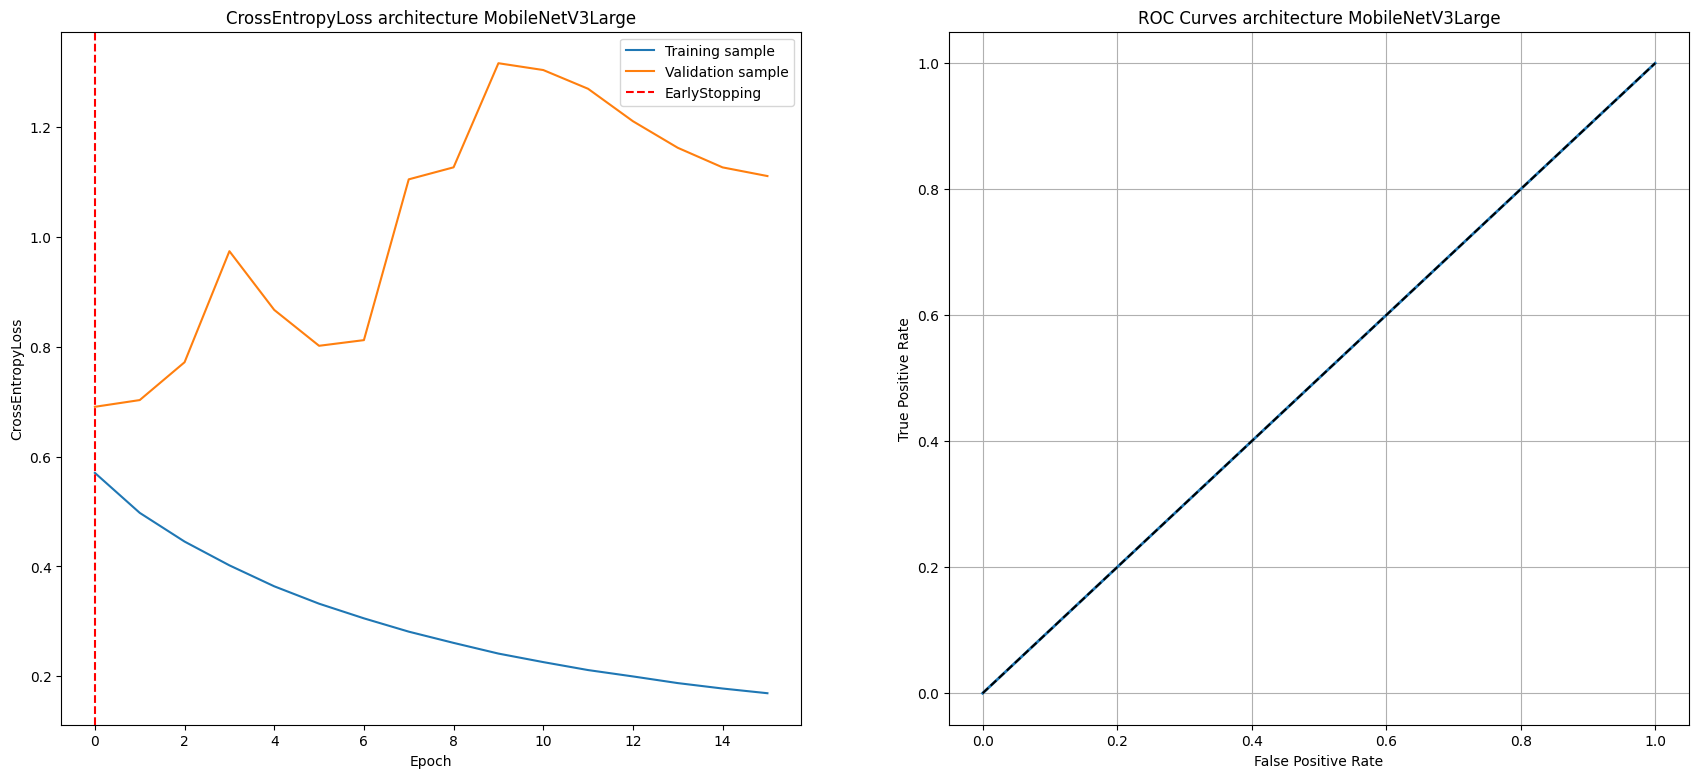

In [15]:
model = models.mobilenet_v3_large() # Loading structure and weights
model.classifier = torch.nn.Linear(960, 2) # Replacing the categorization layer
model.to(device)
name_model = 'MobileNetV3Large'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.3. Training of EffecientNet_B0 neural network architecture

Training of EffecientNet_B0 neural network architecture
[  1/100] loss train: 0.62572 | loss valid: 1.48870
Validation loss decreased (inf --> 1.48870).  Saving model ...
[  2/100] loss train: 0.56174 | loss valid: 0.99866
Validation loss decreased (1.48870 --> 0.99866).  Saving model ...
[  3/100] loss train: 0.52030 | loss valid: 0.81369
Validation loss decreased (0.99866 --> 0.81369).  Saving model ...
[  4/100] loss train: 0.49137 | loss valid: 0.73241
Validation loss decreased (0.81369 --> 0.73241).  Saving model ...
[  5/100] loss train: 0.45981 | loss valid: 0.67617
Validation loss decreased (0.73241 --> 0.67617).  Saving model ...
[  6/100] loss train: 0.43413 | loss valid: 0.61914
Validation loss decreased (0.67617 --> 0.61914).  Saving model ...
[  7/100] loss train: 0.40846 | loss valid: 0.58117
Validation loss decreased (0.61914 --> 0.58117).  Saving model ...
[  8/100] loss train: 0.38302 | loss valid: 0.54717
Validation loss decreased (0.58117 --> 0.54717).  Saving model 

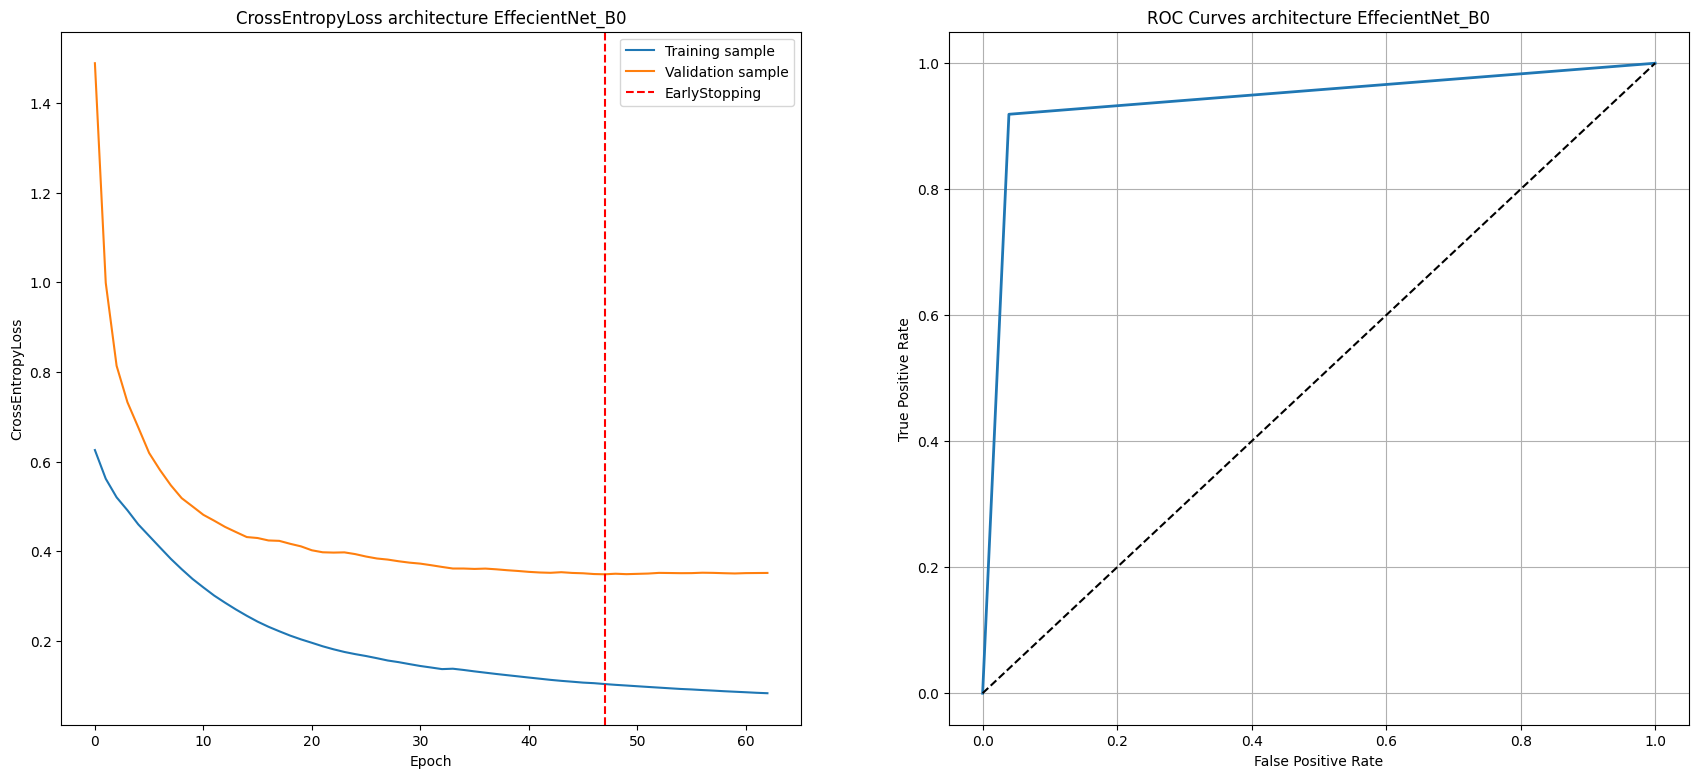

In [16]:
model = models.efficientnet_b0() # Loading structure and weights
model.classifier = torch.nn.Linear(1280, 2) # Replacing the categorization layer
model.to(device)
name_model = 'EffecientNet_B0'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.4. Training of MNASNET1_3 neural network architecture

Training of MNASNET1_3 neural network architecture
[  1/100] loss train: 0.56140 | loss valid: 0.68848
Validation loss decreased (inf --> 0.68848).  Saving model ...
[  2/100] loss train: 0.48325 | loss valid: 0.69031
EarlyStopping counter: 1 out of 15
[  3/100] loss train: 0.43724 | loss valid: 0.70801
EarlyStopping counter: 2 out of 15
[  4/100] loss train: 0.40273 | loss valid: 0.75650
EarlyStopping counter: 3 out of 15
[  5/100] loss train: 0.37293 | loss valid: 0.78529
EarlyStopping counter: 4 out of 15
[  6/100] loss train: 0.34402 | loss valid: 0.81794
EarlyStopping counter: 5 out of 15
[  7/100] loss train: 0.31721 | loss valid: 0.86197
EarlyStopping counter: 6 out of 15
[  8/100] loss train: 0.29489 | loss valid: 0.89506
EarlyStopping counter: 7 out of 15
[  9/100] loss train: 0.27470 | loss valid: 0.95407
EarlyStopping counter: 8 out of 15
[ 10/100] loss train: 0.25635 | loss valid: 1.02008
EarlyStopping counter: 9 out of 15
[ 11/100] loss train: 0.24104 | loss valid: 1.06630

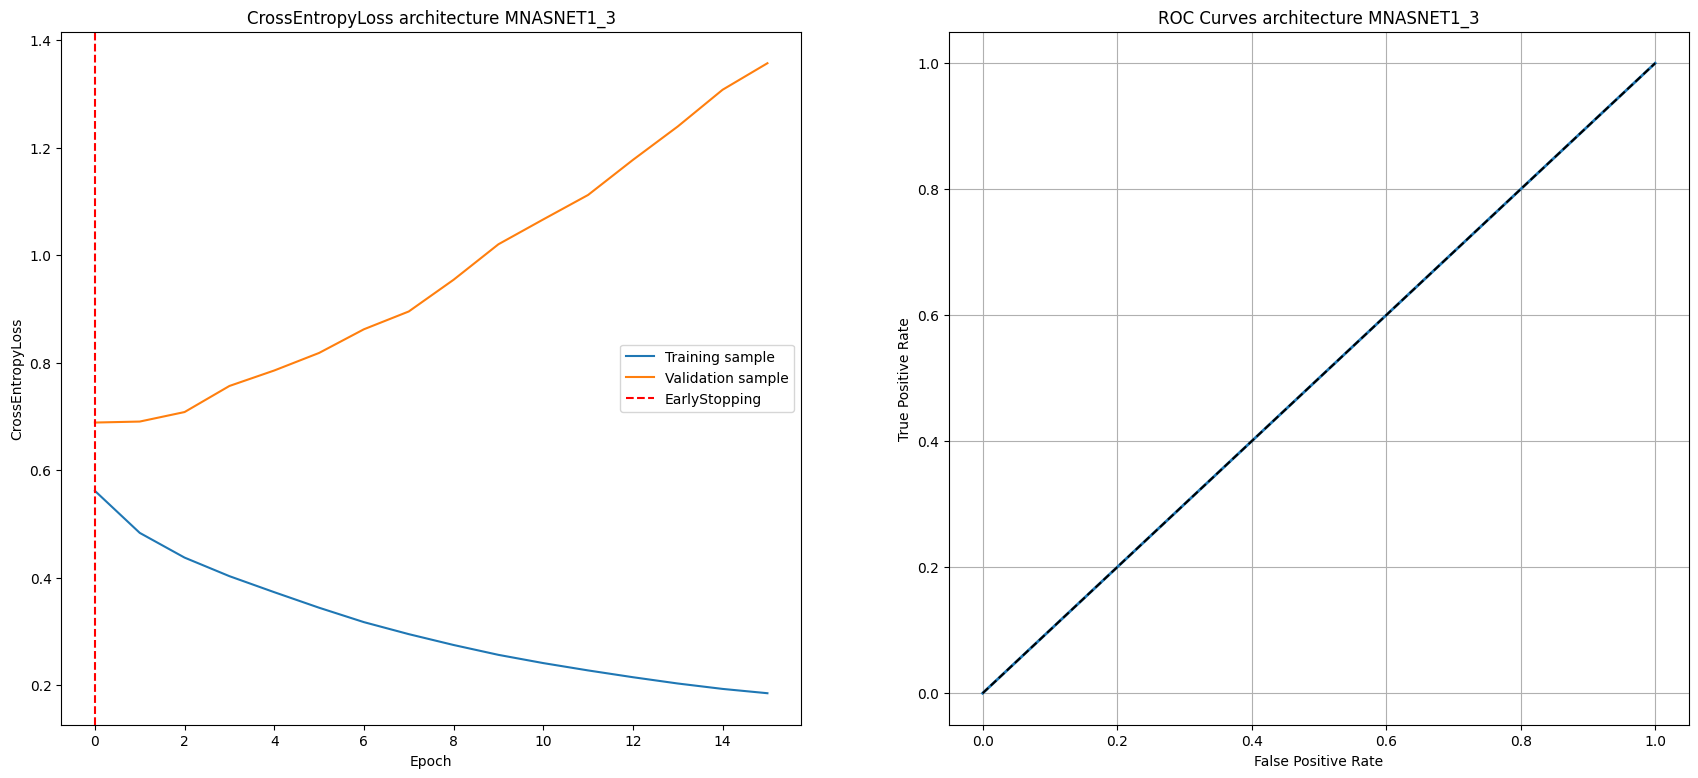

In [17]:
model = models.mnasnet1_3() # Loading structure and weights
model.classifier = torch.nn.Linear(1280, 2) # Replacing the categorization layer
model.to(device)
name_model = 'MNASNET1_3'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.5. Training of the ResNet18 neural network architecture

Training of ResNet18 neural network architecture
[  1/100] loss train: 0.78573 | loss valid: 0.50876
Validation loss decreased (inf --> 0.50876).  Saving model ...
[  2/100] loss train: 0.62652 | loss valid: 0.63218
EarlyStopping counter: 1 out of 15
[  3/100] loss train: 0.55901 | loss valid: 0.59540
EarlyStopping counter: 2 out of 15
[  4/100] loss train: 0.51932 | loss valid: 0.59694
EarlyStopping counter: 3 out of 15
[  5/100] loss train: 0.48757 | loss valid: 0.59185
EarlyStopping counter: 4 out of 15
[  6/100] loss train: 0.46230 | loss valid: 0.57285
EarlyStopping counter: 5 out of 15
[  7/100] loss train: 0.44010 | loss valid: 0.54552
EarlyStopping counter: 6 out of 15
[  8/100] loss train: 0.42075 | loss valid: 0.53284
EarlyStopping counter: 7 out of 15
[  9/100] loss train: 0.40629 | loss valid: 0.52475
EarlyStopping counter: 8 out of 15
[ 10/100] loss train: 0.39210 | loss valid: 0.52175
EarlyStopping counter: 9 out of 15
[ 11/100] loss train: 0.37812 | loss valid: 0.51603
E

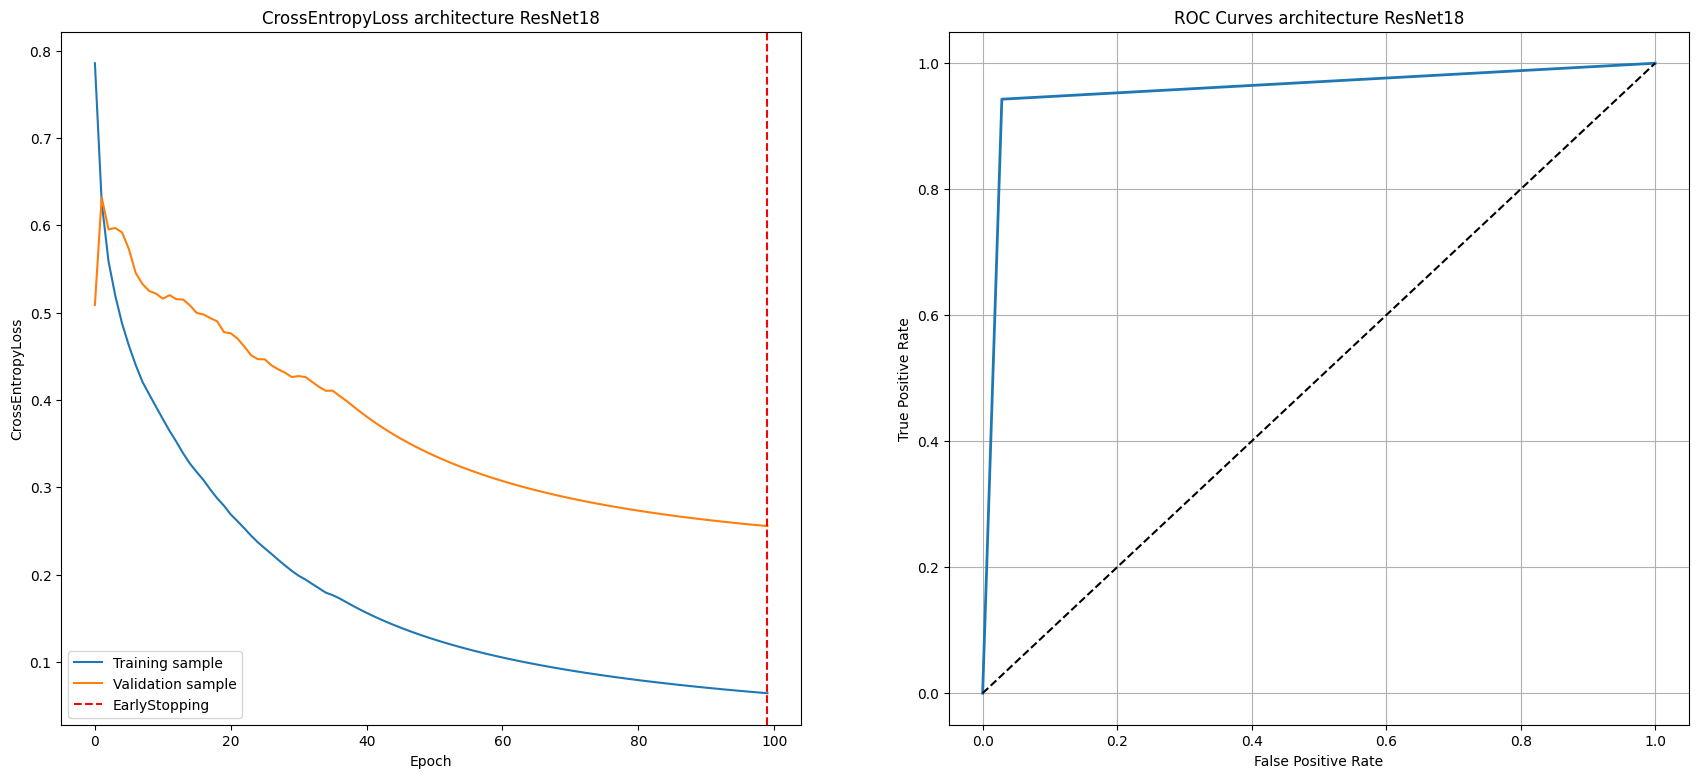

In [18]:
model = models.resnet18() # Loading structure and weights
model.classifier = torch.nn.Linear(1000, 2) # Replacing the categorization layer
model.to(device)
name_model = 'ResNet18'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.6. Training of YOLOv5 neural network architecture

Using cache found in C:\Users\k1rsn/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-12-18 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Training of YOLOv5s neural network architecture
[  1/100] loss train: 0.53974 | loss valid: 0.51305
Validation loss decreased (inf --> 0.51305).  Saving model ...
[  2/100] loss train: 0.50941 | loss valid: 0.50373
Validation loss decreased (0.51305 --> 0.50373).  Saving model ...
[  3/100] loss train: 0.49296 | loss valid: 0.49639
Validation loss decreased (0.50373 --> 0.49639).  Saving model ...
[  4/100] loss train: 0.48140 | loss valid: 0.49019
Validation loss decreased (0.49639 --> 0.49019).  Saving model ...
[  5/100] loss train: 0.47236 | loss valid: 0.48479
Validation loss decreased (0.49019 --> 0.48479).  Saving model ...
[  6/100] loss train: 0.46490 | loss valid: 0.48001
Validation loss decreased (0.48479 --> 0.48001).  Saving model ...
[  7/100] loss train: 0.45852 | loss valid: 0.47571
Validation loss decreased (0.48001 --> 0.47571).  Saving model ...
[  8/100] loss train: 0.45293 | loss valid: 0.47181
Validation loss decreased (0.47571 --> 0.47181).  Saving model ...
[  9

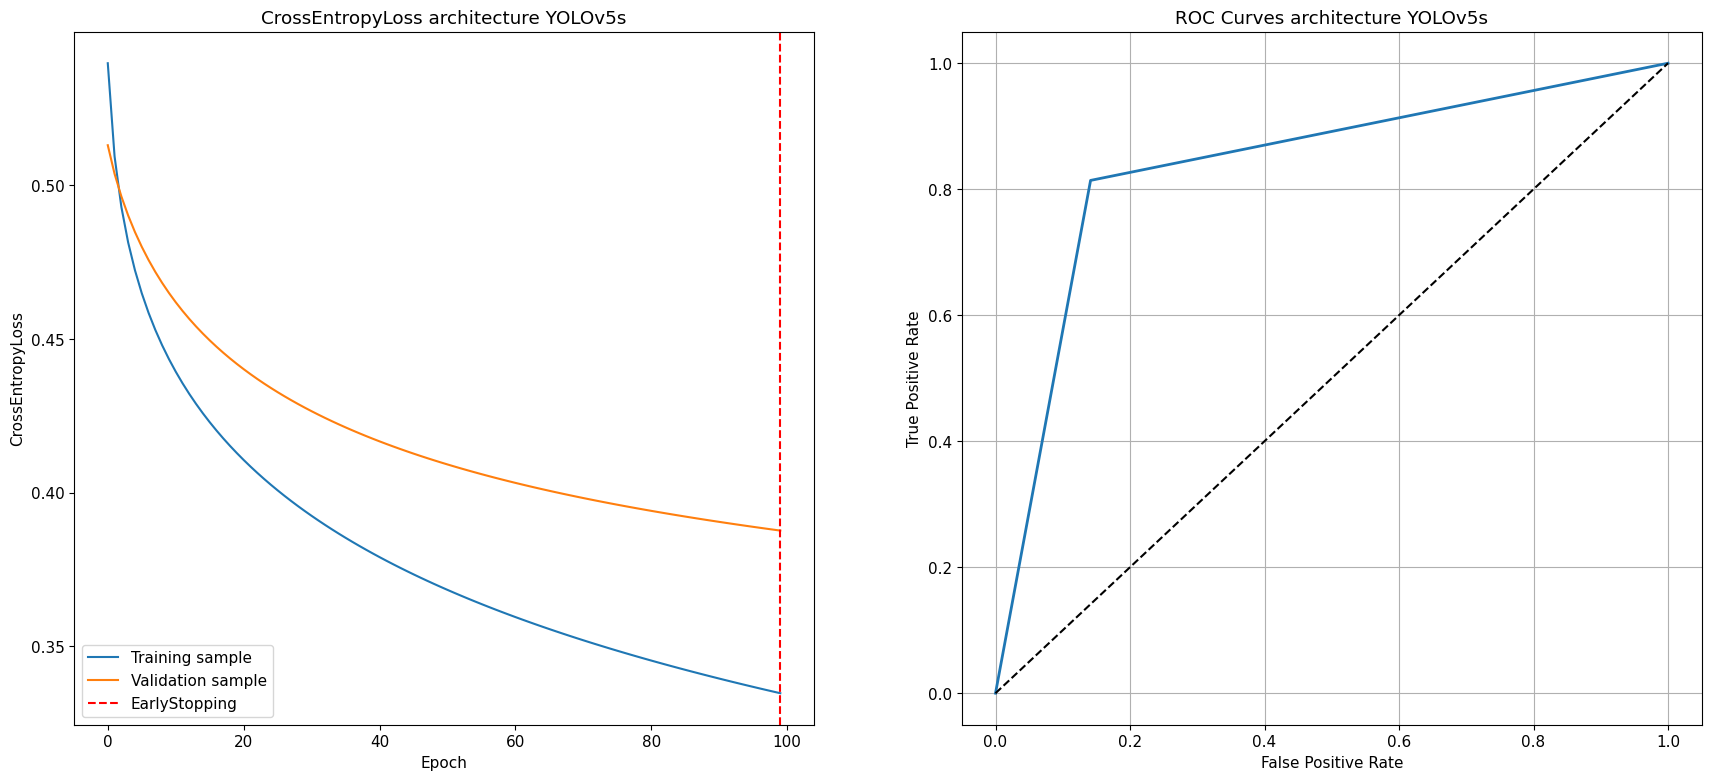

In [19]:
model = torch.hub.load(
    "ultralytics/yolov5", "custom", "yolov5s-cls.pt"
) 
model.model.model[-1].linear  = torch.nn.Linear(1280, 2) # Replacing the categorization layer
model = model.model
model.to(device)
name_model = 'YOLOv5s'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.7. Training of YOLOv8 neural network architecture


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

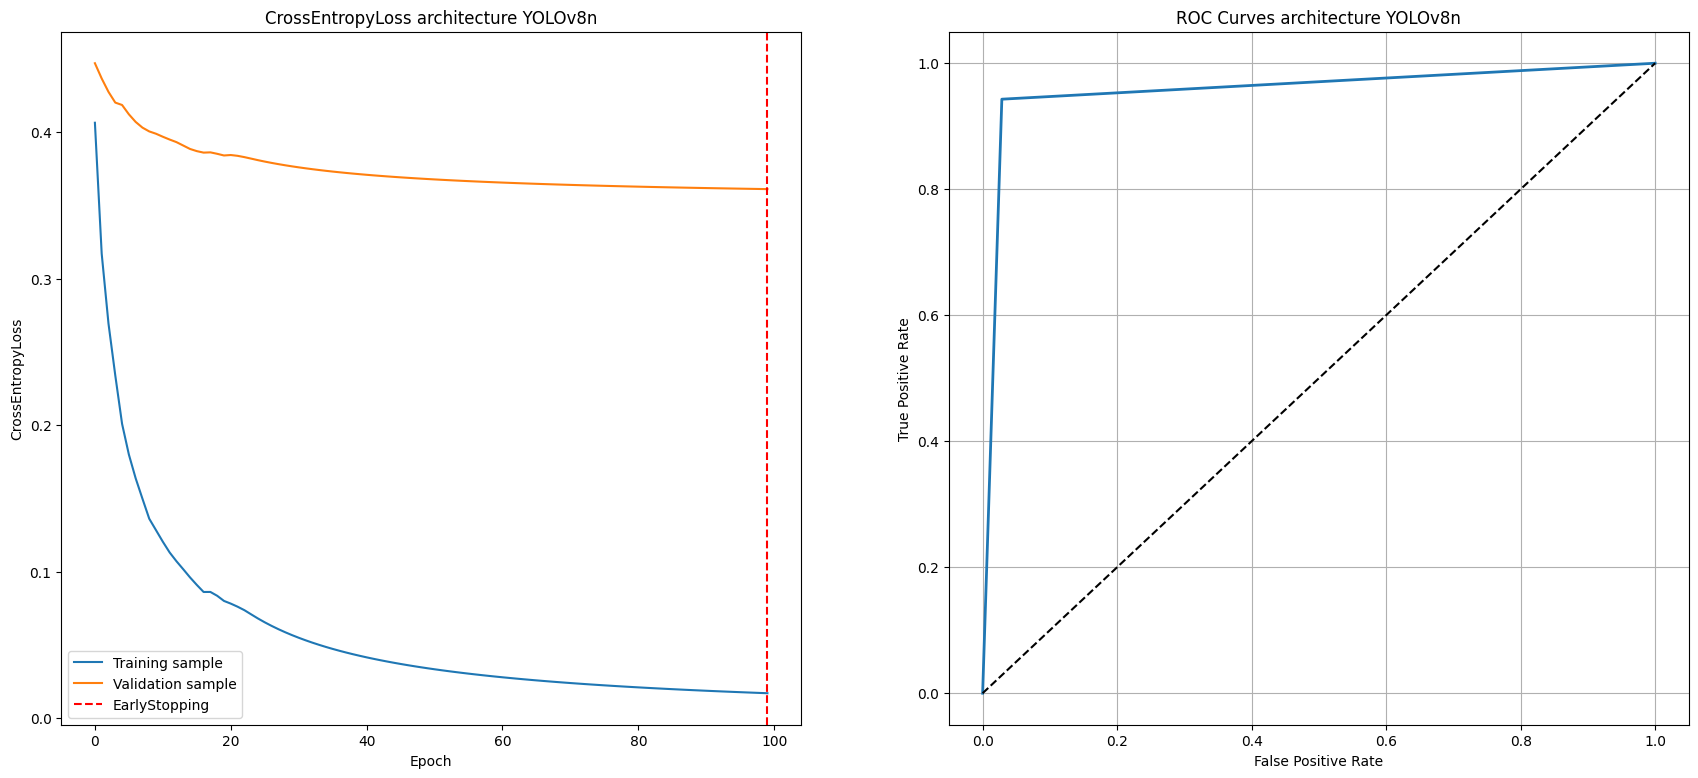

In [20]:
model = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')
model.model.model[-1].linear  = torch.nn.Linear(1280, 2) # Replacing the categorization layer
model = model.model
model.to(device)
name_model = 'YOLOv8n'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.8. Training of REGNET_X_1_6GF neural network architectures

Training of RegNet_y_1_6gf neural network architecture
[  1/100] loss train: 0.79171 | loss valid: 0.58217
Validation loss decreased (inf --> 0.58217).  Saving model ...
[  2/100] loss train: 0.64839 | loss valid: 0.56875
Validation loss decreased (0.58217 --> 0.56875).  Saving model ...
[  3/100] loss train: 0.57845 | loss valid: 0.58119
EarlyStopping counter: 1 out of 15
[  4/100] loss train: 0.52679 | loss valid: 0.54675
Validation loss decreased (0.56875 --> 0.54675).  Saving model ...
[  5/100] loss train: 0.48724 | loss valid: 0.56591
EarlyStopping counter: 1 out of 15
[  6/100] loss train: 0.45367 | loss valid: 0.54318
Validation loss decreased (0.54675 --> 0.54318).  Saving model ...
[  7/100] loss train: 0.42310 | loss valid: 0.53398
Validation loss decreased (0.54318 --> 0.53398).  Saving model ...
[  8/100] loss train: 0.39415 | loss valid: 0.52568
Validation loss decreased (0.53398 --> 0.52568).  Saving model ...
[  9/100] loss train: 0.36992 | loss valid: 0.50677
Validatio

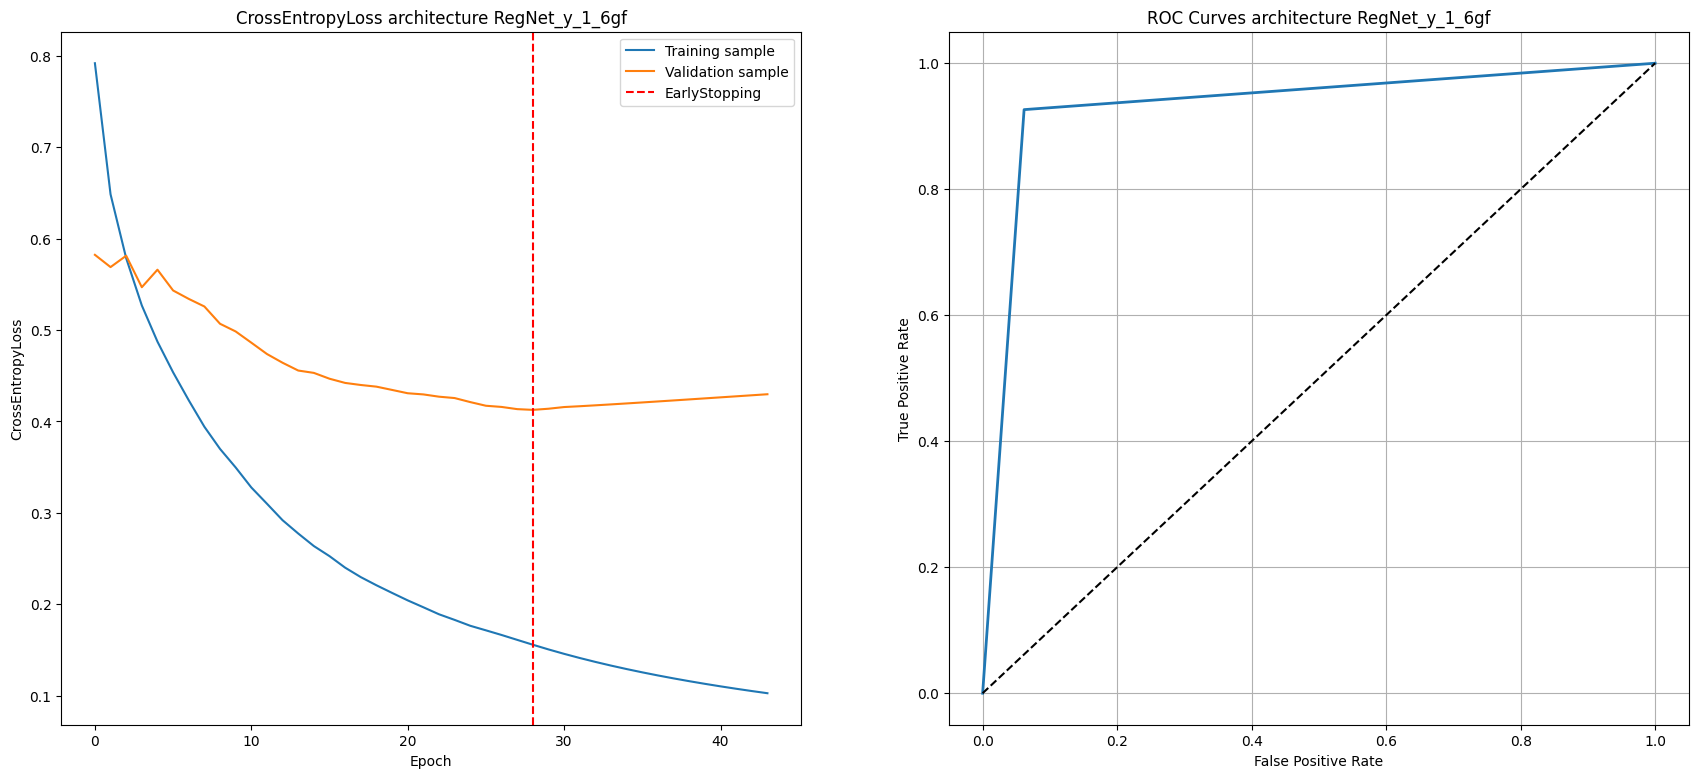

In [21]:
model = models.regnet_y_1_6gf() # Loading structure and weights
model.classifier = torch.nn.Linear(1000, 2) # Replacing the categorization layer
model.to(device)
name_model = 'RegNet_y_1_6gf'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.9 Visualize all models on one graph

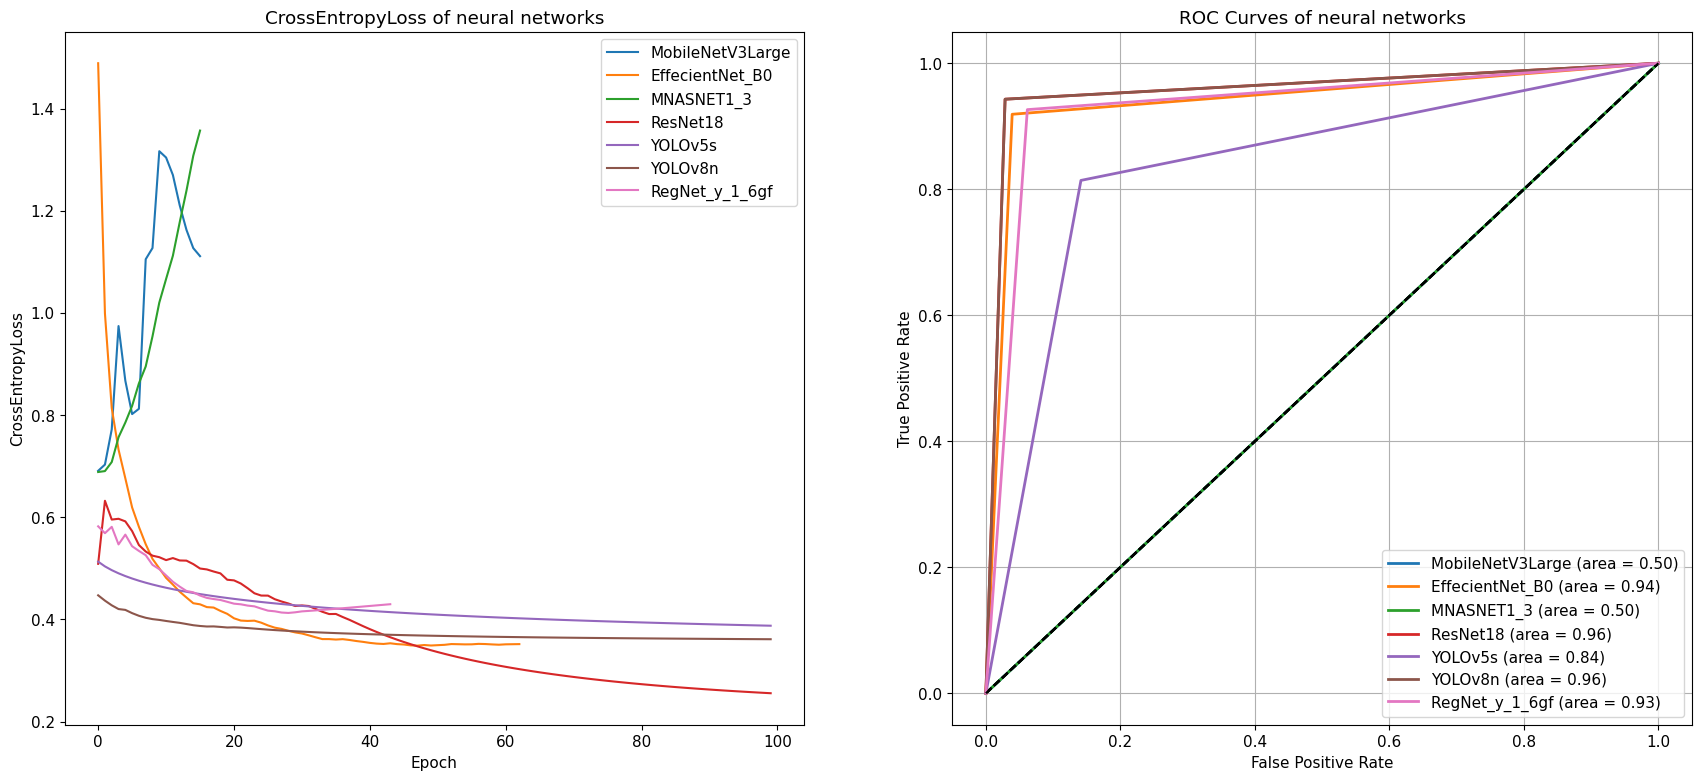

In [22]:
with open('data.json', 'r') as file:
    data = json.load(file)
visualizationNeuralNetworks(data[:7])
del data

According to the results of training of two neural networks we can see that the architectures YOLO and ResNet have the best performance on the ROC curve, but ResNet has the smallest error relative to YOLO, so this architecture will be further trained. But also as an experiment we will train different versions of YOLO architecture


# 4. Exploring different versions of the ResNet architecture
## 4.1. Training the ResNet34 architecture

Training of ResNet34 neural network architecture
[  1/100] loss train: 0.83343 | loss valid: 0.72074
Validation loss decreased (inf --> 0.72074).  Saving model ...
[  2/100] loss train: 0.66930 | loss valid: 0.59328
Validation loss decreased (0.72074 --> 0.59328).  Saving model ...
[  3/100] loss train: 0.59866 | loss valid: 0.56243
Validation loss decreased (0.59328 --> 0.56243).  Saving model ...
[  4/100] loss train: 0.55491 | loss valid: 0.52602
Validation loss decreased (0.56243 --> 0.52602).  Saving model ...
[  5/100] loss train: 0.52127 | loss valid: 0.50573
Validation loss decreased (0.52602 --> 0.50573).  Saving model ...
[  6/100] loss train: 0.49484 | loss valid: 0.49684
Validation loss decreased (0.50573 --> 0.49684).  Saving model ...
[  7/100] loss train: 0.47371 | loss valid: 0.48396
Validation loss decreased (0.49684 --> 0.48396).  Saving model ...
[  8/100] loss train: 0.45413 | loss valid: 0.47565
Validation loss decreased (0.48396 --> 0.47565).  Saving model ...
[  

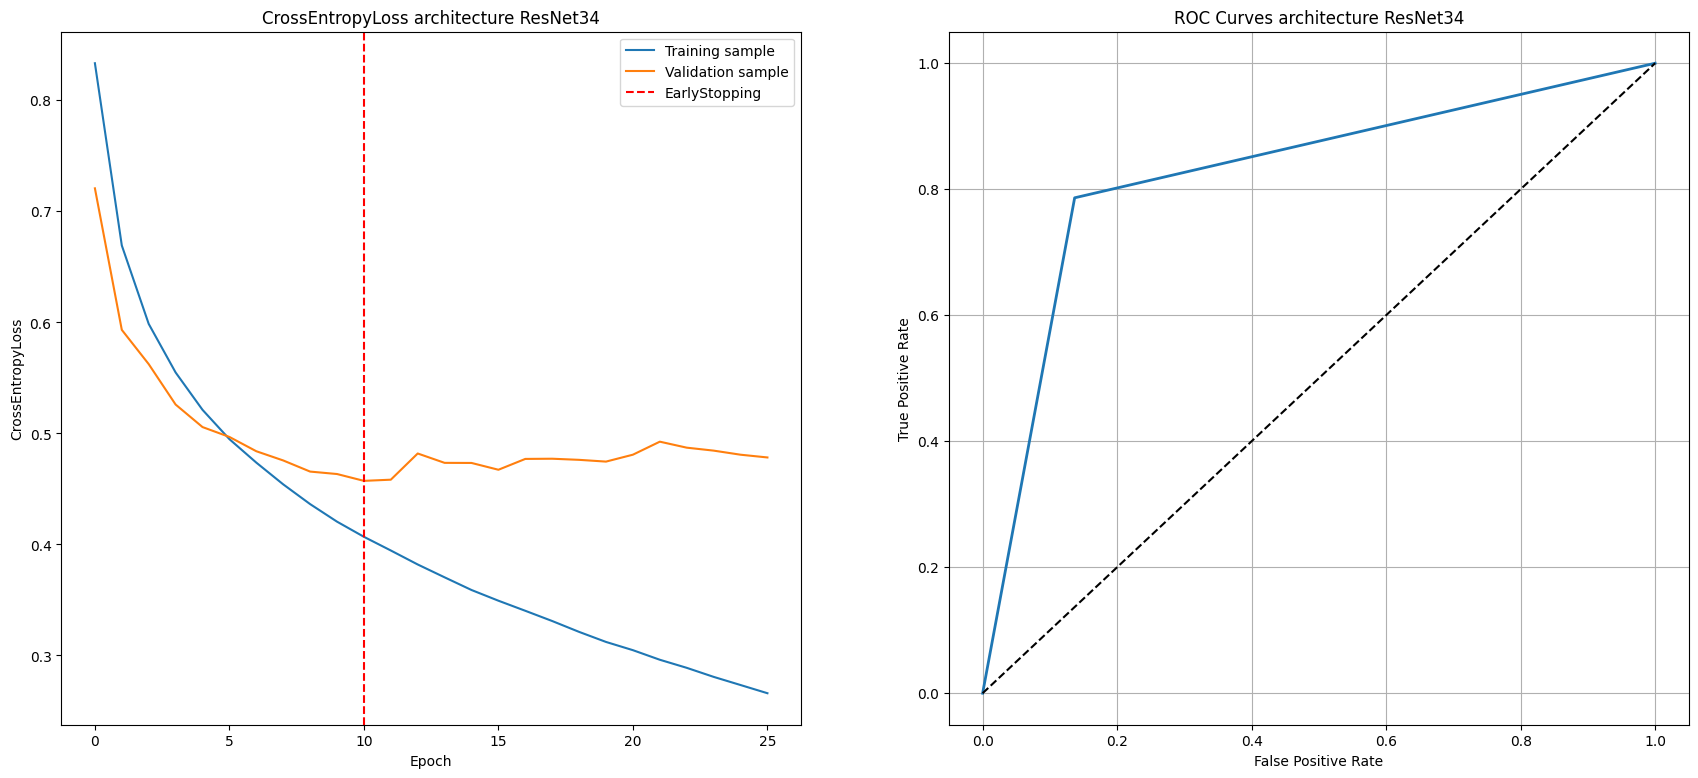

In [23]:
model = models.resnet34() # Loading structure and weights
model.classifier = torch.nn.Linear(1000, 2) # Replacing the categorization layer
model.to(device)
name_model = 'ResNet34'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 4.2. Training the ResNet50 architecture

Training of ResNet50 neural network architecture
[  1/100] loss train: 0.75978 | loss valid: 6.31189
Validation loss decreased (inf --> 6.31189).  Saving model ...
[  2/100] loss train: 0.64859 | loss valid: 3.42634
Validation loss decreased (6.31189 --> 3.42634).  Saving model ...
[  3/100] loss train: 0.59215 | loss valid: 2.44706
Validation loss decreased (3.42634 --> 2.44706).  Saving model ...
[  4/100] loss train: 0.54944 | loss valid: 1.98253
Validation loss decreased (2.44706 --> 1.98253).  Saving model ...
[  5/100] loss train: 0.51395 | loss valid: 1.69801
Validation loss decreased (1.98253 --> 1.69801).  Saving model ...
[  6/100] loss train: 0.48779 | loss valid: 1.49582
Validation loss decreased (1.69801 --> 1.49582).  Saving model ...
[  7/100] loss train: 0.46811 | loss valid: 1.34969
Validation loss decreased (1.49582 --> 1.34969).  Saving model ...
[  8/100] loss train: 0.44565 | loss valid: 1.22604
Validation loss decreased (1.34969 --> 1.22604).  Saving model ...
[  

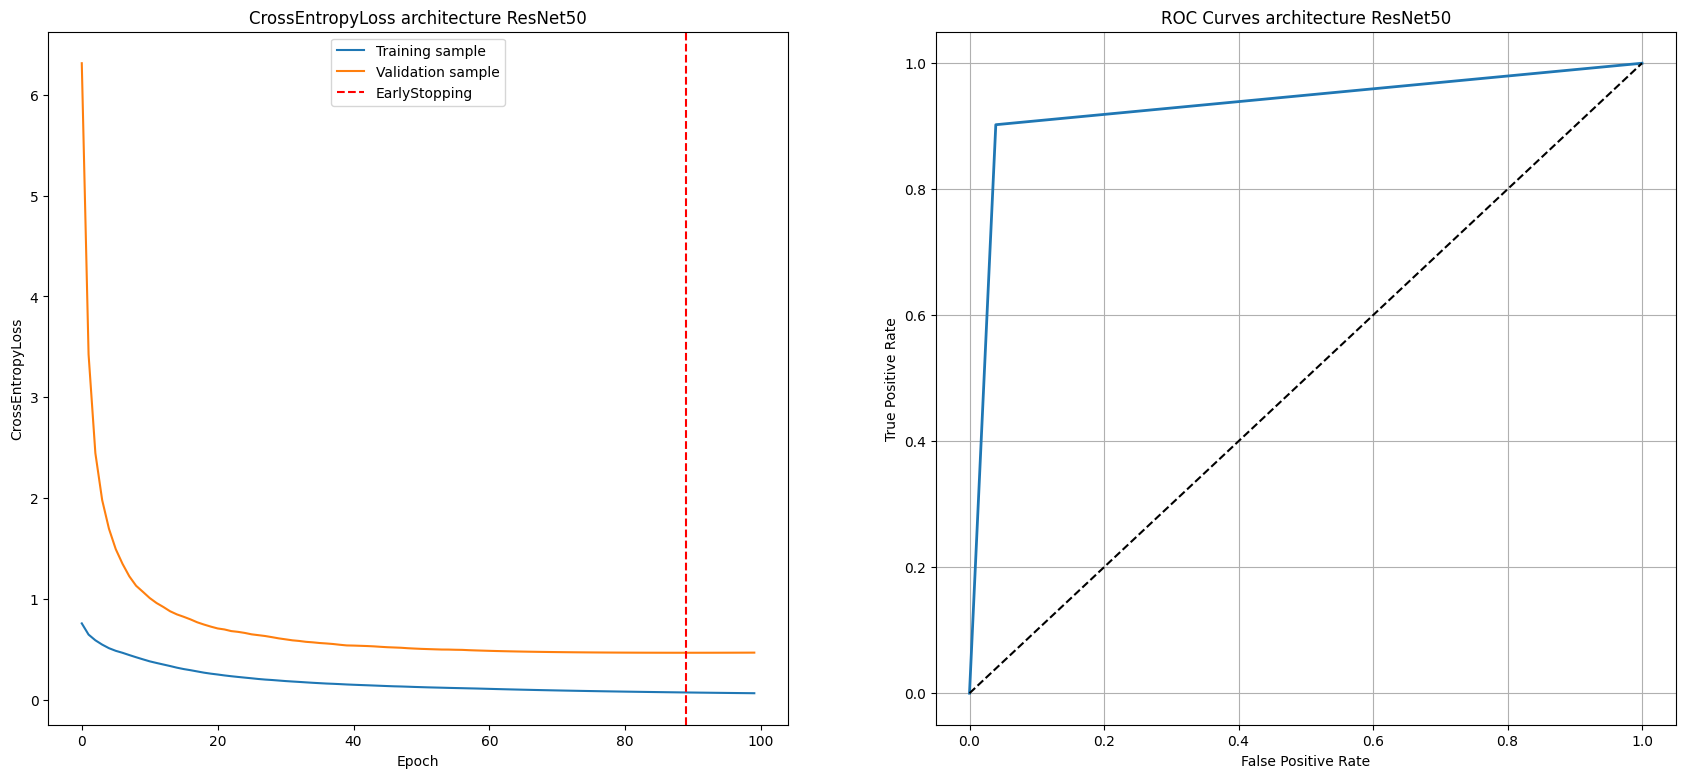

In [24]:
model = models.resnet50() # Loading structure and weights
model.classifier = torch.nn.Linear(1000, 2) # Replacing the categorization layer
model.to(device)
name_model = 'ResNet50'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 4.3. Visualization of ResNet architecture version training results

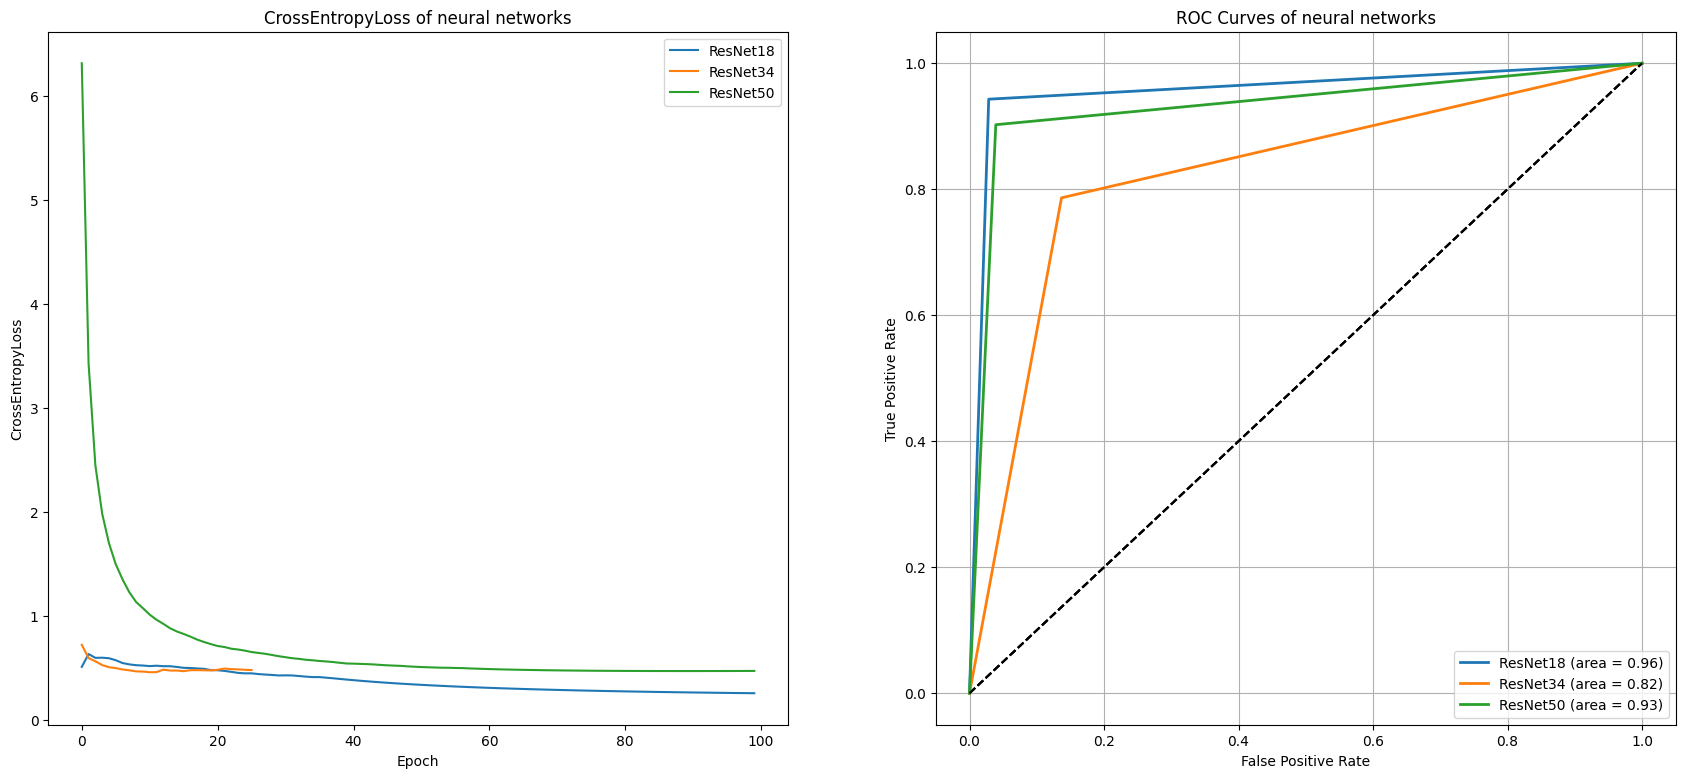

In [25]:
with open('data.json', 'r') as file:
    data = json.load(file)
resnet_data = []
for index in range(len(data)):
    if data[index]['name'].find('ResNet') != -1:
        resnet_data.append(data[index])
visualizationNeuralNetworks(resnet_data, isEnhancement=True)
del data, resnet_data

## 4.4. Training of YOLOv8s architecture


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

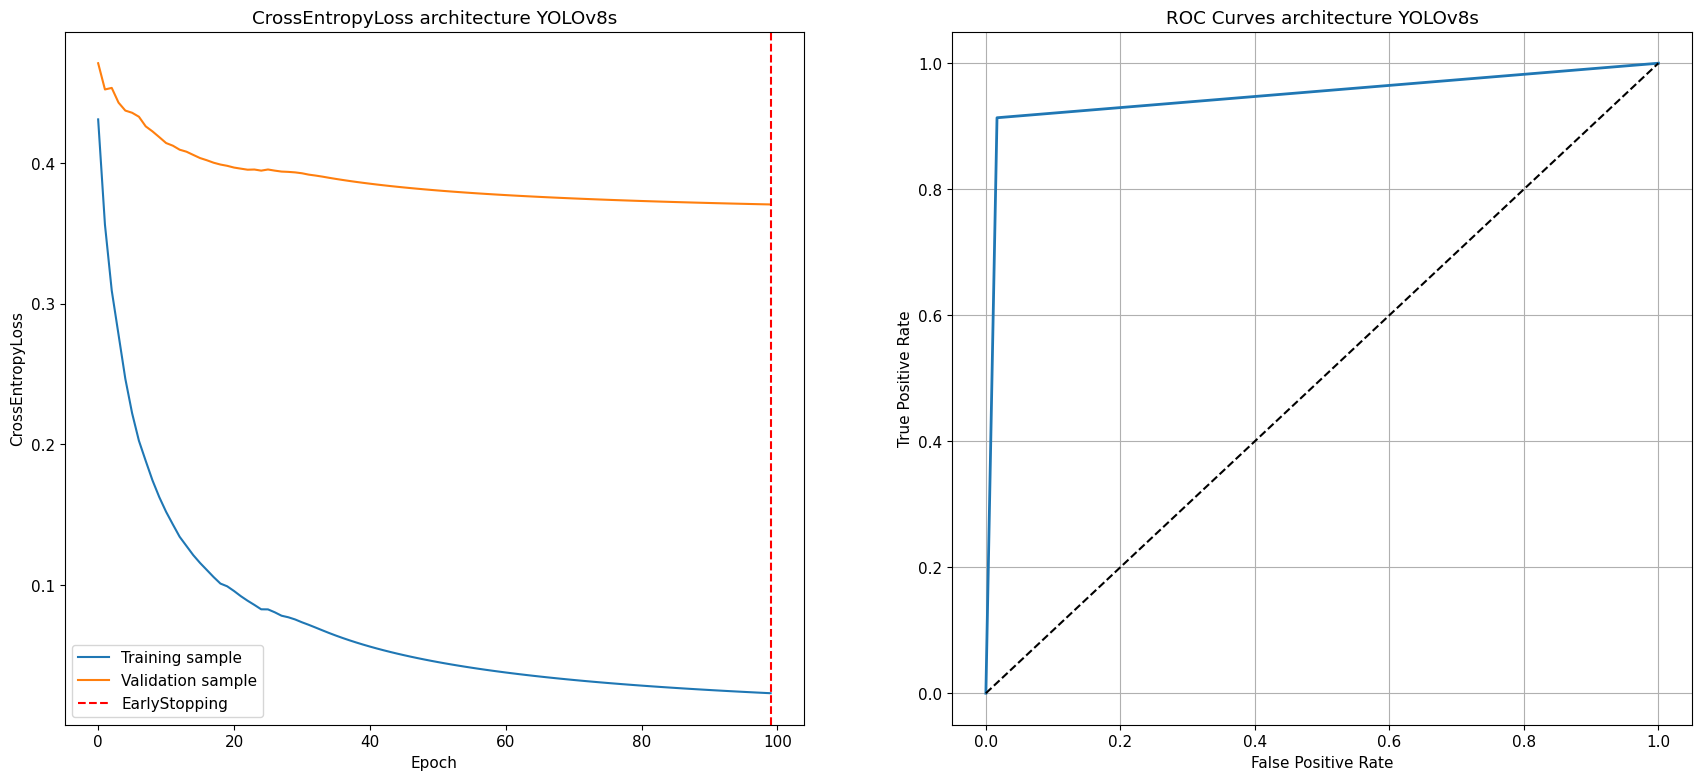

In [26]:
model = YOLO('yolov8s-cls.yaml').load('yolov8s-cls.pt')
model.model.model[-1].linear  = torch.nn.Linear(1280, 2) # Replacing the categorization layer
model = model.model
model.to(device)
name_model = 'YOLOv8s'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 4.5. Training of YOLOv8m architecture


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384

100%|█████████████████████████████████████████████████████████████████████████████| 32.7M/32.7M [00:13<00:00, 2.59MB/s]


Transferred 230/230 items from pretrained weights
Training of YOLOv8m neural network architecture
[  1/100] loss train: 0.48145 | loss valid: 0.51810
Validation loss decreased (inf --> 0.51810).  Saving model ...
[  2/100] loss train: 0.43823 | loss valid: 0.50331
Validation loss decreased (0.51810 --> 0.50331).  Saving model ...
[  3/100] loss train: 0.40358 | loss valid: 0.50036
Validation loss decreased (0.50331 --> 0.50036).  Saving model ...
[  4/100] loss train: 0.37168 | loss valid: 0.48950
Validation loss decreased (0.50036 --> 0.48950).  Saving model ...
[  5/100] loss train: 0.34057 | loss valid: 0.48201
Validation loss decreased (0.48950 --> 0.48201).  Saving model ...
[  6/100] loss train: 0.31695 | loss valid: 0.47525
Validation loss decreased (0.48201 --> 0.47525).  Saving model ...
[  7/100] loss train: 0.29418 | loss valid: 0.46535
Validation loss decreased (0.47525 --> 0.46535).  Saving model ...
[  8/100] loss train: 0.27518 | loss valid: 0.45672
Validation loss decre

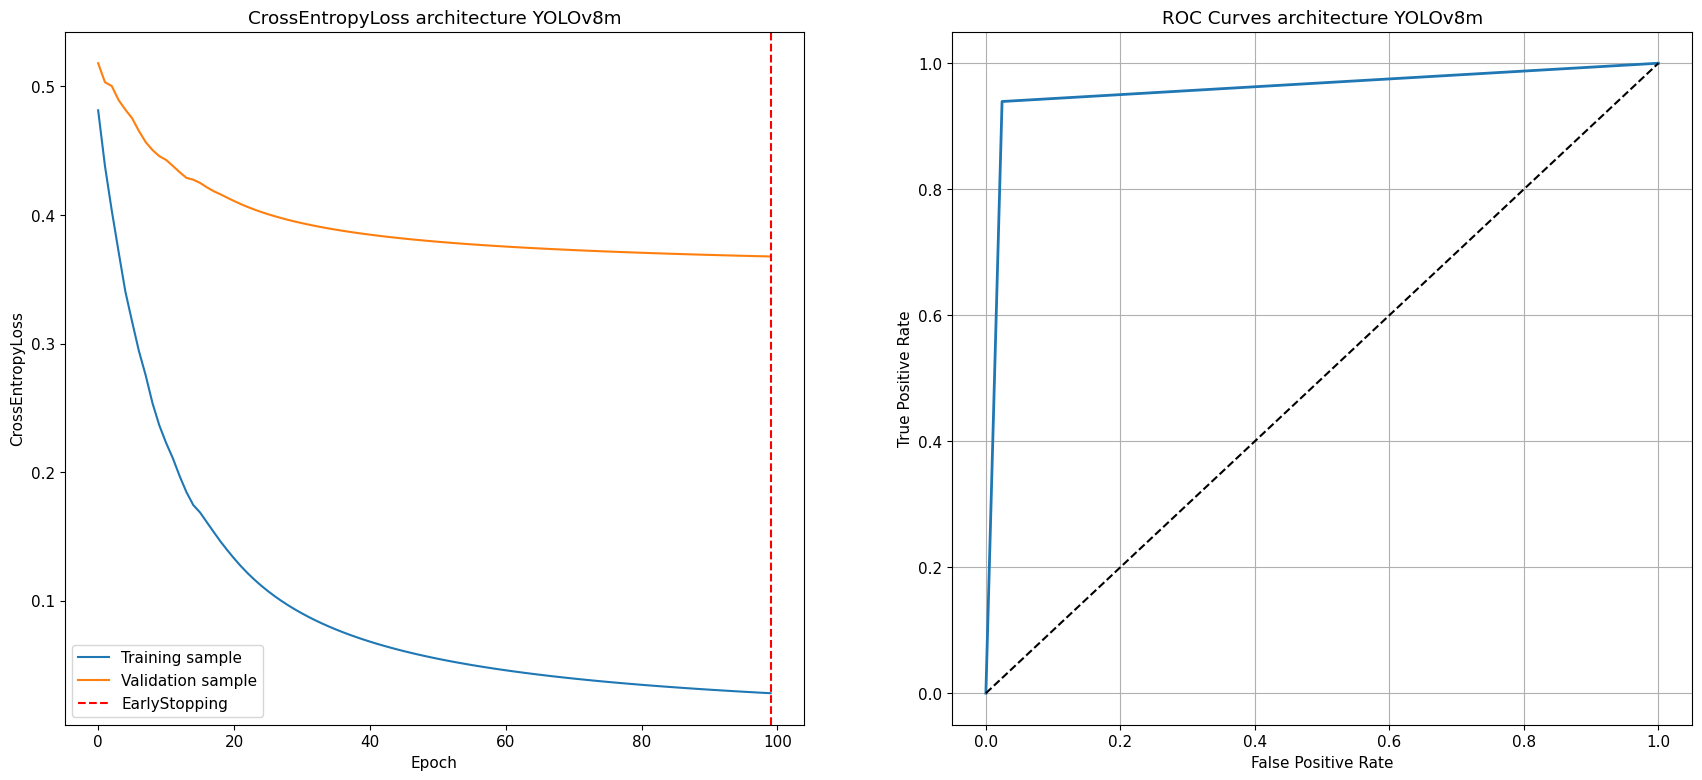

In [27]:
model = YOLO('yolov8m-cls.yaml').load('yolov8m-cls.pt')
model.model.model[-1].linear  = torch.nn.Linear(1280, 2) # Replacing the categorization layer
model = model.model
model.to(device)
name_model = 'YOLOv8m'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 4.6. Visualization of training results of YOLOv8 architecture versions

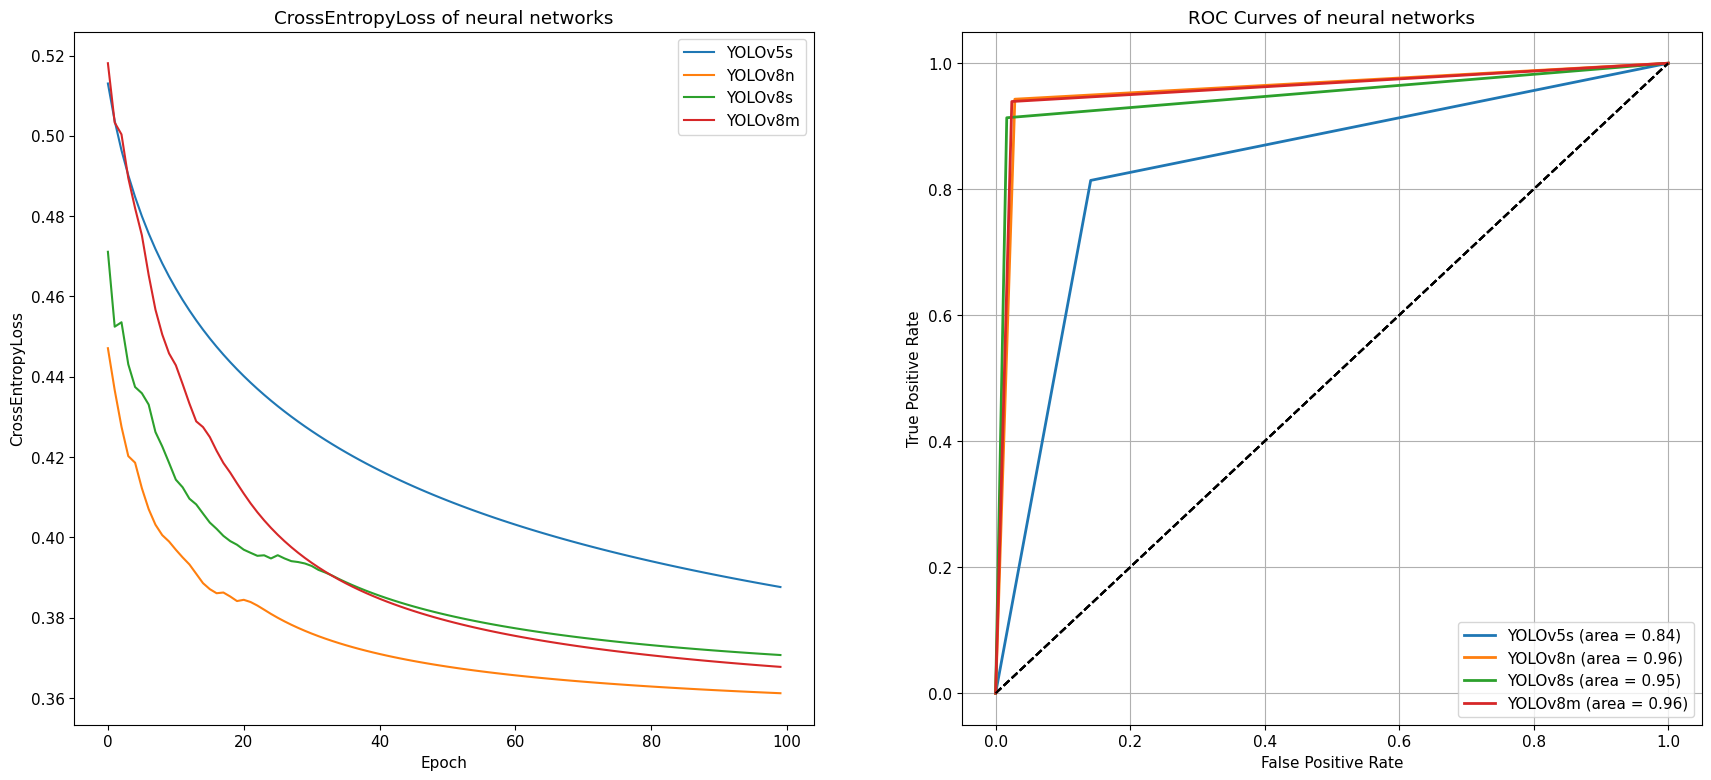

In [28]:
with open('data.json', 'r') as file:
    data = json.load(file)
resnet_data = []
for index in range(len(data)):
    if data[index]['name'].find('YOLO') != -1:
        resnet_data.append(data[index])
visualizationNeuralNetworks(resnet_data, isEnhancement=True)
del data, resnet_data

# 5. Learning the best architecture for neroset
## 5.1. Let's apply all augmentations to images

100%|██████████████████████████████████████████████████████████████████████████████| 1610/1610 [00:37<00:00, 42.52it/s]


CPU times: total: 20.3 s
Wall time: 57.4 s


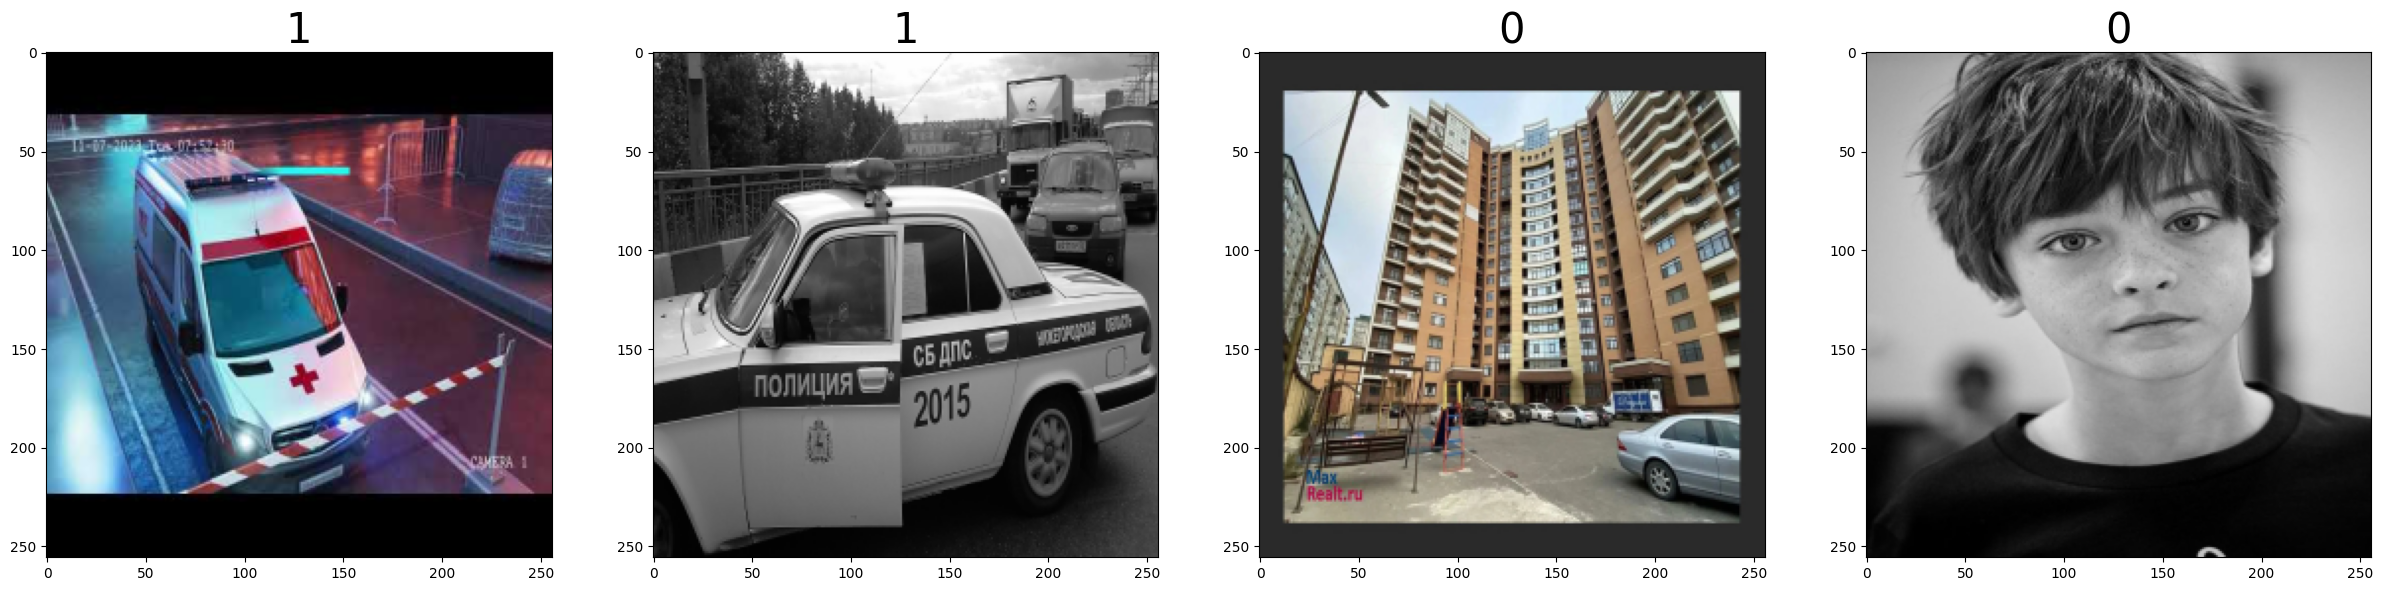

In [29]:
%%time
X = [] # Photographs in matrix format
y = [] # Classes of photographs
for i in tqdm(range(len(data))):
    image = data.loc[i,'src'] # Get the path to the image
    if (data.loc[i, 'label'] == 1): # If there's a special car in the picture
        image = cv2.imread('./Dataset/Spesial_car/'+image, cv2.IMREAD_COLOR) 
    else: # If it's not a special car in the picture
        image = cv2.imread('./Dataset/Rest/'+image, cv2.IMREAD_COLOR) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the color palette of the photo from BGR to RGB 
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_AREA) # Resize the image
    X.append(image) # Add to the dataset
    # We're augmenting the photos
    for transform in [transform1, transform2, transform3, transform4]:
        transformed_image = transform(image=image)
        X.append(transformed_image["image"])
    # Add labels for images
    for _ in range(5):
        y.append(data.loc[i, 'label'])

# Normalize the data
X_torch = np.array(X)
X_torch = X_torch.astype('float32')
X_torch = X_torch / 255.0
X_torch = X_torch.reshape(-1,3, 256, 256)
y_torch = np.array(y).reshape(-1)

# Let's take a couple of examples of the resulting photos
fig, axes = plt.subplots(1, 4, figsize=(30,15))
for i in range(0, 4):
    axes[i].imshow(X[i*y_torch.size//4])
    axes[i].set_title(y[i*y_torch.size//4], fontsize=30)

In [30]:
print(f"Number of Isorations: {X_torch.shape[0]} | Number of tags {y_torch.size}")
print(f"The number of photos after augmentation increased {round(y_torch.size / data.shape[0], 3)} times to {y_torch.size} images") 

Number of Isorations: 8050 | Number of tags 8050
The number of photos after augmentation increased 5.0 times to 8050 images


## 5.2. Formation of training and validation sample, translation of data into tensors.

In [31]:
# Let's define the possibility of photo processing on GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [32]:
# Form a new training and test sample
X_train, X_valid, y_train, y_valid = train_test_split(X_torch, y_torch, random_state=42)
# Let's convert all the data into tensors
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid).float()
y_valid_t = torch.from_numpy(y_valid)

# Generate datasets with samples
train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
train_dataloader = DataLoader(train_dataset, batch_size=31)
valid_dataloader = DataLoader(valid_dataset, batch_size=32) 

# Dictionary with selections
loaders = {"train": train_dataloader, "valid": valid_dataloader}

## 5.3. Training the best version of the neural network

Training of ResNet18-top neural network architecture
[  1/1000] loss train: 0.69102 | loss valid: 0.44763
Validation loss decreased (inf --> 0.44763).  Saving model ...
[  2/1000] loss train: 0.57305 | loss valid: 0.42831
Validation loss decreased (0.44763 --> 0.42831).  Saving model ...
[  3/1000] loss train: 0.52258 | loss valid: 0.40343
Validation loss decreased (0.42831 --> 0.40343).  Saving model ...
[  4/1000] loss train: 0.48685 | loss valid: 0.38808
Validation loss decreased (0.40343 --> 0.38808).  Saving model ...
[  5/1000] loss train: 0.45777 | loss valid: 0.38010
Validation loss decreased (0.38808 --> 0.38010).  Saving model ...
[  6/1000] loss train: 0.43274 | loss valid: 0.36643
Validation loss decreased (0.38010 --> 0.36643).  Saving model ...
[  7/1000] loss train: 0.41028 | loss valid: 0.35997
Validation loss decreased (0.36643 --> 0.35997).  Saving model ...
[  8/1000] loss train: 0.39058 | loss valid: 0.34961
Validation loss decreased (0.35997 --> 0.34961).  Saving m

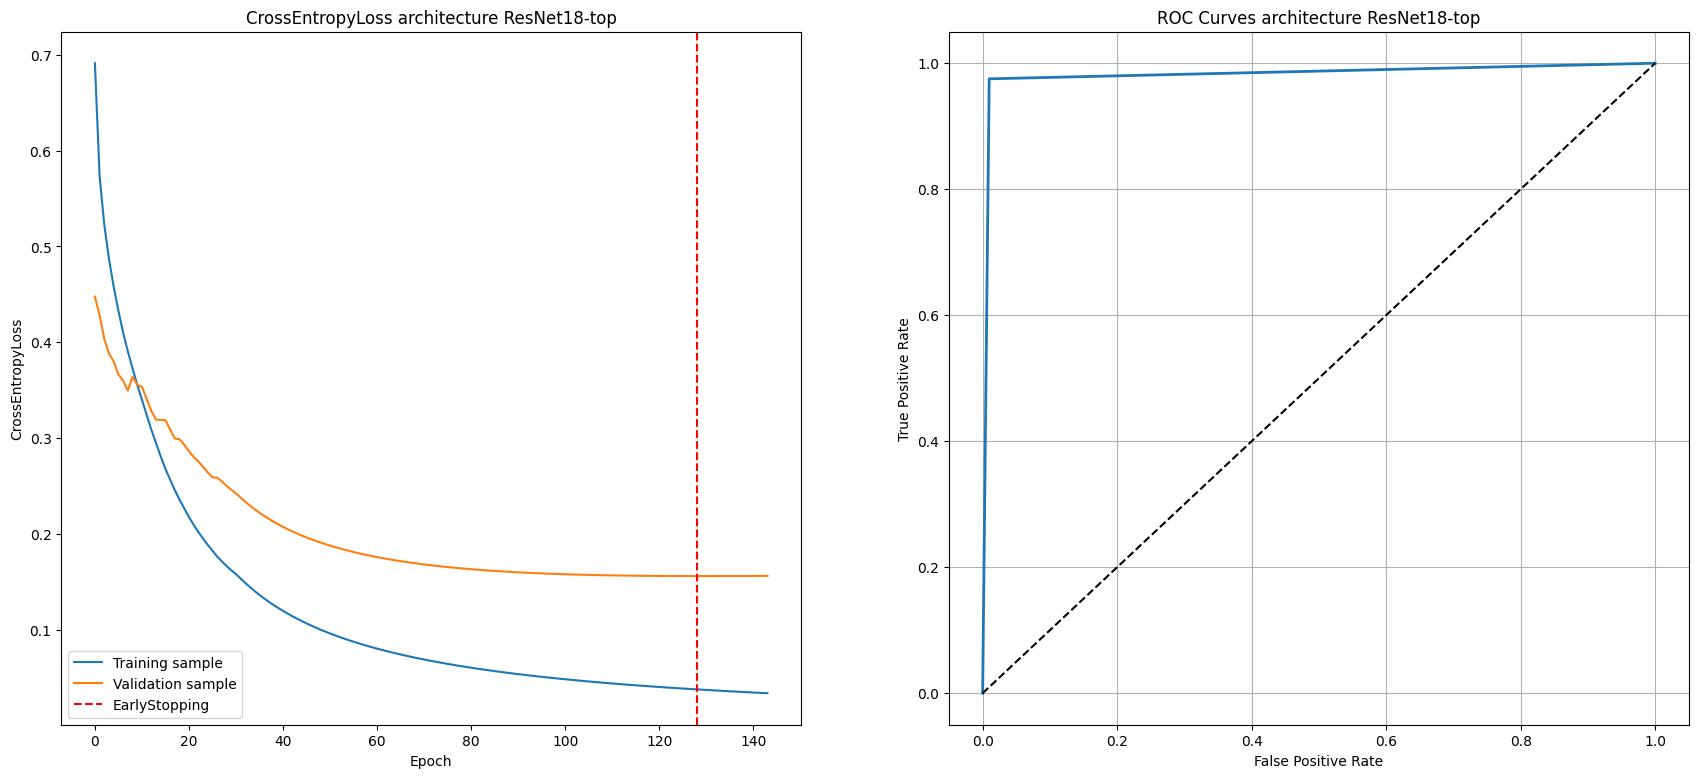

In [33]:
max_epochs_models = 1000 # Maximum number of epochs
epoch_patience_models = 15 # The tolerance of the ages to an early halt
model = models.resnet18() # Loading structure and weights
model.classifier = torch.nn.Linear(1000, 2) # Replacing the categorization layer
model.to(device)
name_model = 'ResNet18-top'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

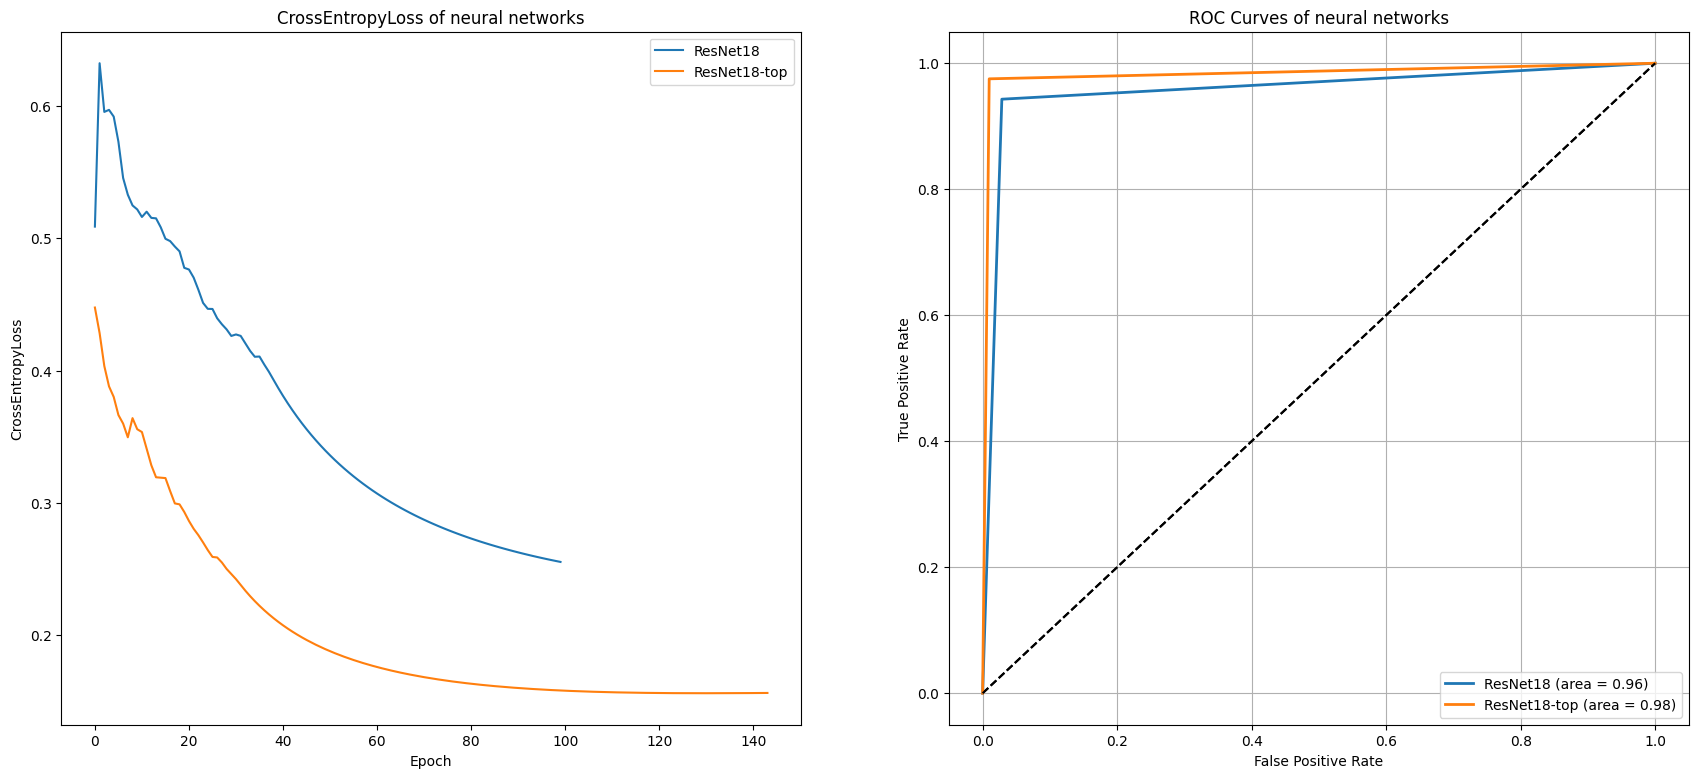

In [35]:
with open('data.json', 'r') as file:
    data = json.load(file)
resnet_data = []
for index in range(len(data)):
    if data[index]['name'].find('ResNet18') != -1:
        resnet_data.append(data[index])
visualizationNeuralNetworks(resnet_data, isEnhancement=True)
del data, resnet_data